### Age Detection of Indian Actors

In [2]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, Dropout
import keras
import imageio # To read images
from PIL import Image # For image resizing 
from clr_callback import * # For cyclic learning rate
from tensorflow.keras.constraints import MaxNorm

In [3]:
# Reading the data
train = pd.read_csv('agedetectiontrain/train.csv')
test = pd.read_csv('agedetectiontest/test.csv')

In [5]:
temp = []
for img_name in train.ID:
    img_path = os.path.join('agedetectiontrain/Train', img_name)
    img = imageio.imread(img_path)
    img = np.array(Image.fromarray(img).resize((32, 32))).astype('float32')    
    temp.append(img)

train_x = np.stack(temp)

C:\Users\anaswara\AppData\Local\Temp\ipykernel_2428\22312541.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [6]:
# Image resizing of test data into single numpy array
temp = []
for img_name in test.ID:
    img_path = os.path.join('agedetectiontest/Test', img_name)
    img = imageio.imread(img_path)
    img = np.array(Image.fromarray(img).resize((32, 32))).astype('float32')    
    temp.append(img)

test_x = np.stack(temp)

C:\Users\anaswara\AppData\Local\Temp\ipykernel_2428\3830458602.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [7]:
# Normalizing the images
train_x = train_x / 255.
test_x = test_x / 255.

In [9]:
# Encoding the categorical variable to numeric
lb = LabelEncoder()
train_y = lb.fit_transform(train.Class)
train_y = keras.utils.to_categorical(train_y)

### Building a Deep Neural Network for Age Group Detection

In [10]:
# Specifying all the parameters we will be using in our network
input_num_units = (32, 32, 3)
hidden_num_units = 500
output_num_units = 3

# Optimum values
optimizer = keras.optimizers.Adam()
activation = 'relu'
cb_triangular_lr = CyclicLR(base_lr=0.0001, max_lr=0.001, step_size=2000., mode='triangular2') 
weights = keras.initializers.he_normal()
bias = keras.initializers.Constant(value=0.01)
dropout = 0.30
regularizer = keras.regularizers.l2()
epochs = 21
batch_size = 128

In [11]:
# Defining the network
model = Sequential([
  InputLayer(input_shape=input_num_units),
  Flatten(),
  Dense(units=hidden_num_units, kernel_initializer=weights, 
        bias_initializer=bias, activation=activation, 
       kernel_constraint=keras.constraints.maxnorm(3),
       kernel_regularizer=regularizer),
  Dropout(dropout),
  Dense(units=output_num_units, kernel_initializer=weights, activation='softmax'),
])

c:\Users\anaswara\anaconda3\envs\deepl-env\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


AttributeError: module 'keras.constraints' has no attribute 'maxnorm'

In [9]:
# Printing model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1536500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1503      
Total params: 1,538,003
Trainable params: 1,538,003
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compiling and Training Network
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cb_save = keras.callbacks.TensorBoard(log_dir='optimum_model', write_graph=False) 
model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_split=0.2, callbacks = [cb_triangular_lr, cb_save])

Train on 15924 samples, validate on 3982 samples
Epoch 1/21
15924/15924 [==============================] - 21s 1ms/step - loss: 8.9983 - acc: 0.5651 - val_loss: 6.9456 - val_acc: 0.6160
Epoch 2/21
15924/15924 [==============================] - 19s 1ms/step - loss: 5.3936 - acc: 0.6039 - val_loss: 3.9865 - val_acc: 0.6321
Epoch 3/21
15924/15924 [==============================] - 18s 1ms/step - loss: 3.1117 - acc: 0.6093 - val_loss: 2.3439 - val_acc: 0.6311
Epoch 4/21
15924/15924 [==============================] - 19s 1ms/step - loss: 1.9257 - acc: 0.6121 - val_loss: 1.5302 - val_acc: 0.6286
Epoch 5/21
15924/15924 [==============================] - 20s 1ms/step - loss: 1.3726 - acc: 0.5992 - val_loss: 1.1645 - val_acc: 0.6318
Epoch 6/21
15924/15924 [==============================] - 19s 1ms/step - loss: 1.0912 - acc: 0.6116 - val_loss: 0.9994 - val_acc: 0.6308
Epoch 7/21
15924/15924 [==============================] - 20s 1ms/step - loss: 0.9678 - acc: 0.6150 - val_loss: 0.9713 - val_acc:

### Saving the model in H5 format

In [11]:
model.save('optimum_model.h5')

In [13]:
# Predicting and importing the result in a csv file
pred = model.predict_classes(test_x)
pred = lb.inverse_transform(pred)

test['Class'] = pred
test.to_csv('out.csv', index=False)

Original: MIDDLE Predicted: MIDDLE


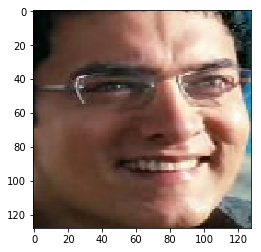

In [20]:
# Visual Inspection of predictions
idx = 2481
img_name = test.ID[idx]

img = imageio.imread(os.path.join('age_detection_test/Test', img_name))
plt.imshow(np.array(Image.fromarray(img).resize((128, 128))))
pred = model.predict_classes(test_x)
print('Original:', train.Class[idx], 'Predicted:', lb.inverse_transform(pred)[idx])